# Иерархическая кластеризация


culmen_length_mm: culmen length (mm)

culmen_depth_mm: culmen depth (mm)

flipper_length_mm: flipper length (mm)

body_mass_g: body mass (g)

sex: penguin sex

In [28]:
import warnings
warnings.filterwarnings("ignore")
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
import math

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import AgglomerativeClustering, DBSCAN



print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/11_Hierarchy


## 1) Загрузка данных

In [29]:
train_df = pd.read_csv('train.csv')


print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))


Размер данных:  (344, 5)
 culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g    sex
             39.1             18.7              181.0       3750.0   MALE
             39.5             17.4              186.0       3800.0 FEMALE
             40.3             18.0              195.0       3250.0 FEMALE
              NaN              NaN                NaN          NaN    NaN
             36.7             19.3              193.0       3450.0 FEMALE


## 2) Анализ

In [30]:
# EDA: Исследование данных
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB
None
       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        342.000000       342.000000         342.000000   342.000000
mean          43.921930        17.151170         214.014620  4201.754386
std            5.459584         1.974793         260.558057   801.954536
min           32.100000        13.100000        -132.000000  2700.000000
25%           39.225000        15.600000         190.000000  3550.000000
50%           44.450000        17.300000         197.000000  405

In [31]:
print("\nПропуски:")
print(train_df.isnull().sum())
print("\nУникальные значения:")
print(train_df['sex'].unique())


Пропуски:
culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

Уникальные значения:
['MALE' 'FEMALE' nan '.']


In [32]:
# Удаление некорректных значений в столбце 'sex'
train_df = train_df[train_df['sex'].isin(['MALE', 'FEMALE'])]
print('\nРазмер данных: ', train_df.shape)
print("\nПропуски:")
print(train_df.isnull().sum())
print("\nУникальные значения в sex:")
print(train_df['sex'].unique())
print(train_df[:5])
# Удаление некорректных значений в столбце 'flipper_length_mm'
train_df = train_df[(train_df['flipper_length_mm'] > 0) & (train_df['flipper_length_mm'] <= 300)]

train_df['sex'] = LabelEncoder().fit_transform(train_df['sex'])
print("\nУникальные значения в flipper_length_mm:")
print(train_df['flipper_length_mm'].unique())
print(train_df[:5])


Размер данных:  (334, 5)

Пропуски:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Уникальные значения в sex:
['MALE' 'FEMALE']
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
4              36.7             19.3              193.0       3450.0  FEMALE
5              39.3             20.6              190.0       3650.0    MALE

Уникальные значения в flipper_length_mm:
[181. 186. 195. 193. 190. 182. 191. 185. 197. 184. 194. 174. 180. 189.
 187. 183. 172. 178. 188. 196. 200. 192. 198. 202. 205. 208. 203. 199.
 176. 210. 201. 212. 206. 207. 211. 230. 218. 215. 219. 209. 214. 216.
 213. 217. 221. 222. 220. 225. 224. 231. 229. 223. 228. 226.]
   culmen_

## 3) Кластеризация AgglomerativeClustering

In [33]:
df = train_df

In [34]:
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_score = -1
best_params = {}
best_score1 = -100
best_params1 = {}
adjusted_score = []
for n_clusters in range(2, 7):
    for linkage1 in ['ward', 'complete', 'average', 'single']:
        try:
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage1)
            labels = model.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)

            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage1}
        
        except Exception as e:
            continue

print(f"Лучшие параметры для AgglomerativeClustering: {best_params} с силуэт-оценкой: {best_score:.3f}")

best_score = -1
best_params = {}

for n_clusters in range(2, 7):
    for linkage1 in ['ward', 'complete', 'average', 'single']:
        try:
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage1)
            labels = model.fit_predict(X_scaled)
            score = adjusted_rand_score(df['sex'], labels)
            
            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage1}
        except Exception as e:
            continue

print(f"Лучшие параметры для AgglomerativeClustering: {best_params} с ARI-оценкой: {best_score:.3f}")



Лучшие параметры для AgglomerativeClustering: {'n_clusters': 2, 'linkage': 'ward'} с силуэт-оценкой: 0.531
Лучшие параметры для AgglomerativeClustering: {'n_clusters': 6, 'linkage': 'ward'} с ARI-оценкой: 0.213


## 4) Дендрограмма

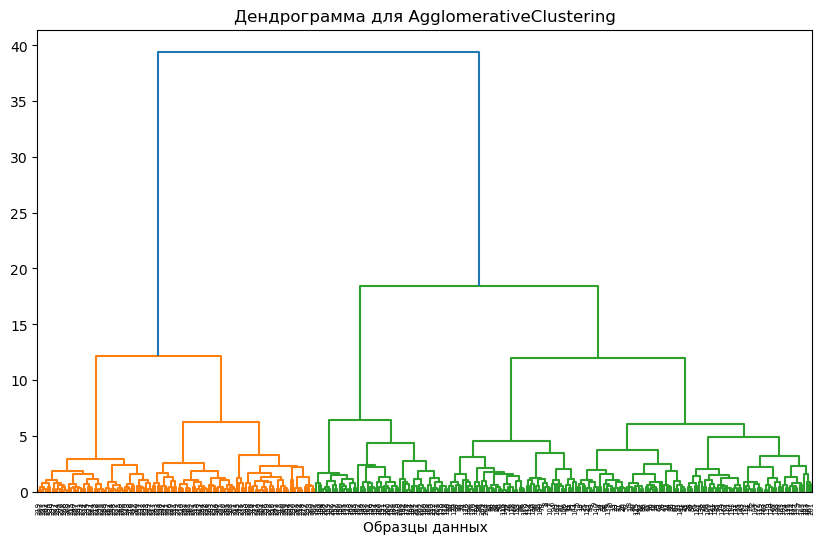

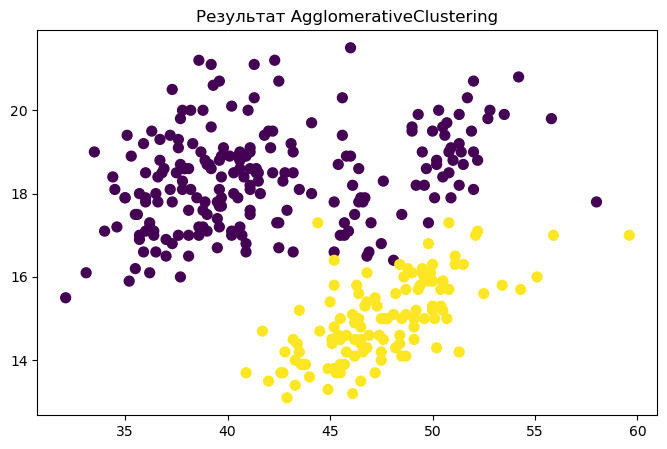

In [35]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title('Дендрограмма для AgglomerativeClustering')
plt.xlabel('Образцы данных')
plt.ylabel('')
plt.show()

model = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels = model.fit_predict(X_scaled)


plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.title('Результат AgglomerativeClustering')
plt.show()


## 5) Сохранение

In [36]:
import joblib

joblib.dump(model, 'kmeans_model.joblib')

print("Модель успешно сохранена в файл 'kmeans_model.joblib'")

Модель успешно сохранена в файл 'kmeans_model.joblib'


## 6)

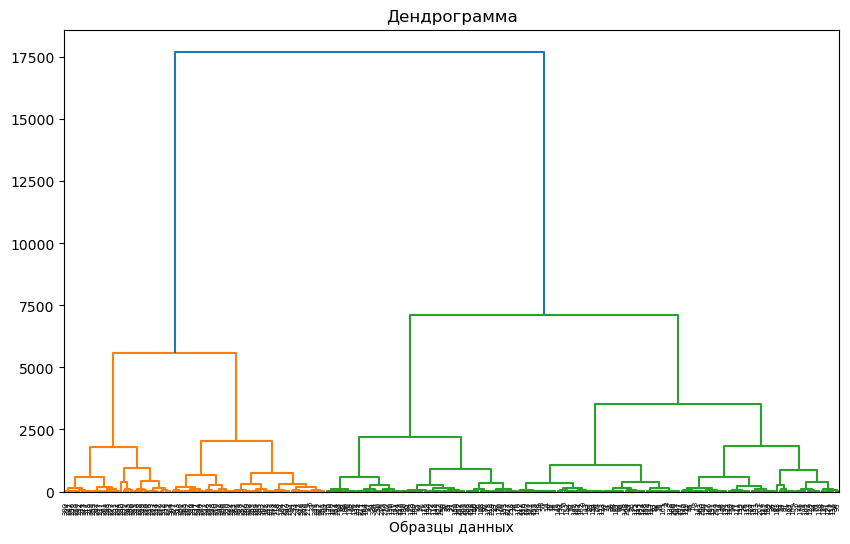

Лучшие параметры: {'linkage': 'complete', 'metric': 'cosine'}
Лучшая оценка ARI: 0.1196


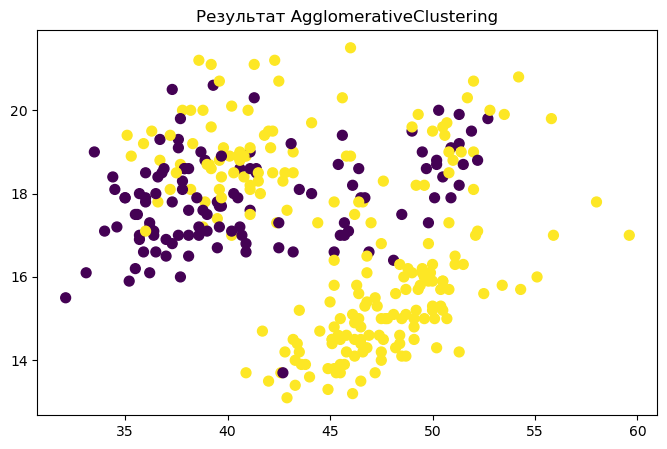

In [37]:

X = df.drop(['sex'], axis=1).values
y_true = df['sex'].values  
linked = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title('Дендрограмма')
plt.xlabel('Образцы данных')
plt.ylabel('')
plt.show()

best_score = -1
best_params = {}

for linkage1 in ['ward', 'complete', 'average', 'single']:
    for metric in ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']:
        try:
            model = AgglomerativeClustering(n_clusters=2, linkage=linkage1, metric=metric)
            labels = model.fit_predict(X)

            score = adjusted_rand_score(y_true, labels)
            
            if score > best_score:
                best_score = score
                best_params = {'linkage': linkage1, 'metric': metric}
                
        except ValueError:
            continue

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая оценка ARI: {best_score:.4f}")

model = AgglomerativeClustering(n_clusters=2, **best_params)
labels = model.fit_predict(X)

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.title('Результат AgglomerativeClustering')
plt.show()


## 7) DBSCAN

Лучшие параметры для DBSCAN: {'eps': np.float64(0.8500000000000002), 'min_samples': 3} силуэт: 0.508
Оценка ARI: -0.0028


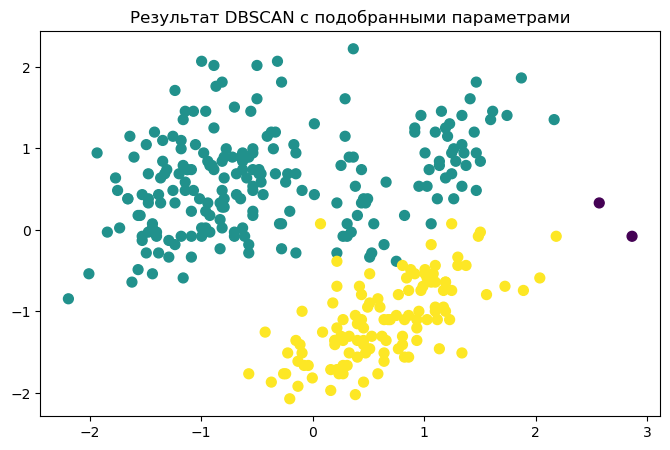

In [38]:
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[features].values

# Отбираем по силуэту
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_dbscan_score = -1
best_dbscan_params = {}

for eps in np.arange(0.1, 1.0, 0.05):
    for min_samples in range(3, 60):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_scaled)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X_scaled, labels)
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_params = {'eps': eps, 'min_samples': min_samples}
                score_adjusted = adjusted_rand_score(y_true, labels)

print(f"Лучшие параметры для DBSCAN: {best_dbscan_params} силуэт: {best_dbscan_score:.3f}")
print(f"Оценка ARI: {score_adjusted:.4f}")

model = DBSCAN(**best_dbscan_params)
labels = model.fit_predict(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.title('Результат DBSCAN с подобранными параметрами')
plt.show()



Лучшие параметры: {'eps': np.float64(0.8500000000000002), 'min_samples': 53}
Лучшая оценка ARI: 0.2195
Силуэт: 0.1244


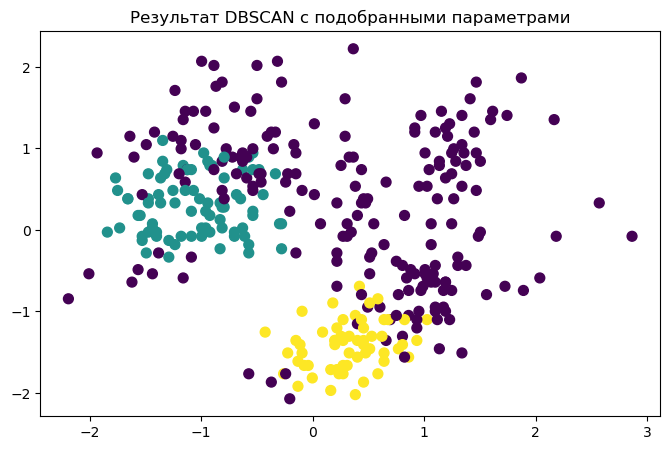

In [39]:
# Отбираем по adjusted_rand_score
best_score = -1
best_params = {}

eps_values = np.arange(0.1, 2.0, 0.05)    
min_samples_values = range(2, 60)        

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_scaled)

        
        if len(set(labels)) < 2:
            continue  

        score = adjusted_rand_score(y_true, labels)
        
        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}
            score_silhouette = silhouette_score(X_scaled, labels)


print(f"Лучшие параметры: {best_params}")
print(f"Лучшая оценка ARI: {best_score:.4f}")
print(f"Силуэт: {score_silhouette:.4f}")
model = DBSCAN(**best_params)
labels = model.fit_predict(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.title('Результат DBSCAN с подобранными параметрами')
plt.show()


#### Отбирая по  adjusted_rand_score результат  силуэта хуже  
Отбирая методом силуэта получаем 
оложительный Silhouette Score (0.508) говорит о том, что модель формирует кластеры  
Низкий или отрицательный ARI (−0.0028) показывает, что эти кластеры не совпадают с истинными метками.